# 🛠 Exercises

## 0. Prerequisites

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
# Get data
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteBHKEZ8/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteBHKEZ8/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [3]:
# Check info
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir=PosixGPath('/tmp/tmphu2cdsq9tfds'),
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examp

In [4]:
# Get class names
class_names = ds_info.features['label'].names

In [5]:
# Preprocessing function
def preprocess_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, dtype=tf.float32), label

In [6]:
# Preprocess train data
train_data_prep = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data_prep = train_data_prep.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Preprocess test data
test_data_prep = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data_prep = test_data_prep.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data_prep, test_data_prep

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [7]:
# Download and unzip model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
!unzip 07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip

--2023-12-17 02:05:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.207, 74.125.69.207, 64.233.181.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46790356 (45M) [application/zip]
Saving to: ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  44.62M   122MB/s    in 0.4s    

2023-12-17 02:05:05 (122 MB/s) - ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’ saved [46790356/46790356]

Archive:  07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
   creating: 07_efficientnetb0_fine_tuned_101_classes_mixed_precision/
   creating: 07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/
  inflating: 07_efficientnetb0_fine_tuned_101_classes_mixed

In [8]:
# Load model
model = tf.keras.models.load_model("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

In [9]:
# Check the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

## 1. Use the same evaluation techniques on the large-scale Food Vision model as you did in the previous notebook ([Transfer Learning Part 3: Scaling up](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb)). More specifically, it would be good to see:
- A confusion matrix between all of the model's predictions and true labels.
- A graph showing the f1-scores of each class.
- A visualization of the model making predictions on various images and comparing the predictions to the ground truth.
    - For example, plot a sample image from the test dataset and have the title of the plot showing the prediction, the prediction probability, and the ground truth label.

In [10]:
# Evaluate a model
result_loss, result_accuracy = model.evaluate(test_data_prep)

790/790 [==============================] - 57s 64ms/step - loss: 0.9072 - accuracy: 0.8015


In [11]:
# Get labels and predictions
y_pred = model.predict(test_data_prep).argmax(axis = 1)
y_true = [y.numpy() for x, y in test_data_prep.unbatch()]

790/790 [==============================] - 54s 66ms/step


In [12]:
# Check y_true and y_pred
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.010217821782178218

In [13]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
        y_true: Array of truth labels (must be same shape as y_pred).
        y_pred: Array of predicted labels (must be same shape as y_true).
        classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
        figsize: Size of output figure (default=(10, 10)).
        text_size: Size of output figure text (default=15).
        norm: normalize values or not (default=False).
        savefig: save confusion matrix to file (default=False).

    Returns:
        A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
        make_confusion_matrix(y_true=test_labels,   # ground truth test labels
                              y_pred=y_preds,       # predicted labels
                              classes=class_names,  # array of class label names
                              figsize=(15, 15),
                              text_size=10)
    """
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]    # normalize it
    n_classes = cm.shape[0]                                         # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes), # create enough axis slots for each class
           yticks=np.arange(n_classes),
           xticklabels=labels,          # axes will labeled with class names (if they exist) or ints
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                    horizontalalignment="center",
                    color="white" if cm[i, j] > threshold else "black",
                    size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                    horizontalalignment="center",
                    color="white" if cm[i, j] > threshold else "black",
                    size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

In [14]:
make_confusion_matrix(y_true=y_true,
                      y_pred=y_pred,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20)

Output hidden; open in https://colab.research.google.com to view.

In [15]:
# F1-scores of each class
from sklearn.metrics import classification_report

report_dict = classification_report(y_true, y_pred, output_dict = True)
report_dict

{'0': {'precision': 0.008032128514056224,
  'recall': 0.008,
  'f1-score': 0.008016032064128256,
  'support': 250},
 '1': {'precision': 0.008368200836820083,
  'recall': 0.008,
  'f1-score': 0.008179959100204498,
  'support': 250},
 '2': {'precision': 0.011811023622047244,
  'recall': 0.012,
  'f1-score': 0.011904761904761906,
  'support': 250},
 '3': {'precision': 0.0038910505836575876,
  'recall': 0.004,
  'f1-score': 0.0039447731755424065,
  'support': 250},
 '4': {'precision': 0.011673151750972763,
  'recall': 0.012,
  'f1-score': 0.011834319526627219,
  'support': 250},
 '5': {'precision': 0.01762114537444934,
  'recall': 0.016,
  'f1-score': 0.01677148846960168,
  'support': 250},
 '6': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 250},
 '7': {'precision': 0.015810276679841896,
  'recall': 0.016,
  'f1-score': 0.015904572564612324,
  'support': 250},
 '8': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 250},
 '9': {'precision': 0.027522935779816515

In [16]:
# Create an empty dictionary
f1_scores = {}

# For-loop to retrieve f1-scores
for k, v in report_dict.items():
    if k == 'accuracy':
        break
    else:
        f1_scores[class_names[int(k)]] = v["f1-score"]
f1_scores

{'apple_pie': 0.008016032064128256,
 'baby_back_ribs': 0.008179959100204498,
 'baklava': 0.011904761904761906,
 'beef_carpaccio': 0.0039447731755424065,
 'beef_tartare': 0.011834319526627219,
 'beet_salad': 0.01677148846960168,
 'beignets': 0.0,
 'bibimbap': 0.015904572564612324,
 'bread_pudding': 0.0,
 'breakfast_burrito': 0.025641025641025644,
 'bruschetta': 0.01276595744680851,
 'caesar_salad': 0.023904382470119518,
 'cannoli': 0.012219959266802444,
 'caprese_salad': 0.0186219739292365,
 'carrot_cake': 0.027131782945736437,
 'ceviche': 0.007984031936127744,
 'cheesecake': 0.003913894324853229,
 'cheese_plate': 0.003937007874015748,
 'chicken_curry': 0.015594541910331385,
 'chicken_quesadilla': 0.0040650406504065045,
 'chicken_wings': 0.00816326530612245,
 'chocolate_cake': 0.01593625498007968,
 'chocolate_mousse': 0.007561436672967863,
 'churros': 0.02012072434607646,
 'clam_chowder': 0.012145748987854251,
 'club_sandwich': 0.0,
 'crab_cakes': 0.011627906976744186,
 'creme_brulee': 

In [17]:
# Dict to data frame
df_f1_scores = pd.DataFrame({"class_name": f1_scores.keys(),
                             "f1-score": f1_scores.values()}).sort_values("f1-score", ascending=False)
df_f1_scores

,class_name,f1-score
58,ice_cream,0.032922
73,panna_cotta,0.028000
14,carrot_cake,0.027132
9,breakfast_burrito,0.025641
33,edamame,0.024096
...,...,...
8,bread_pudding,0.000000
6,beignets,0.000000
70,pad_thai,0.000000
99,tuna_tartare,0.000000


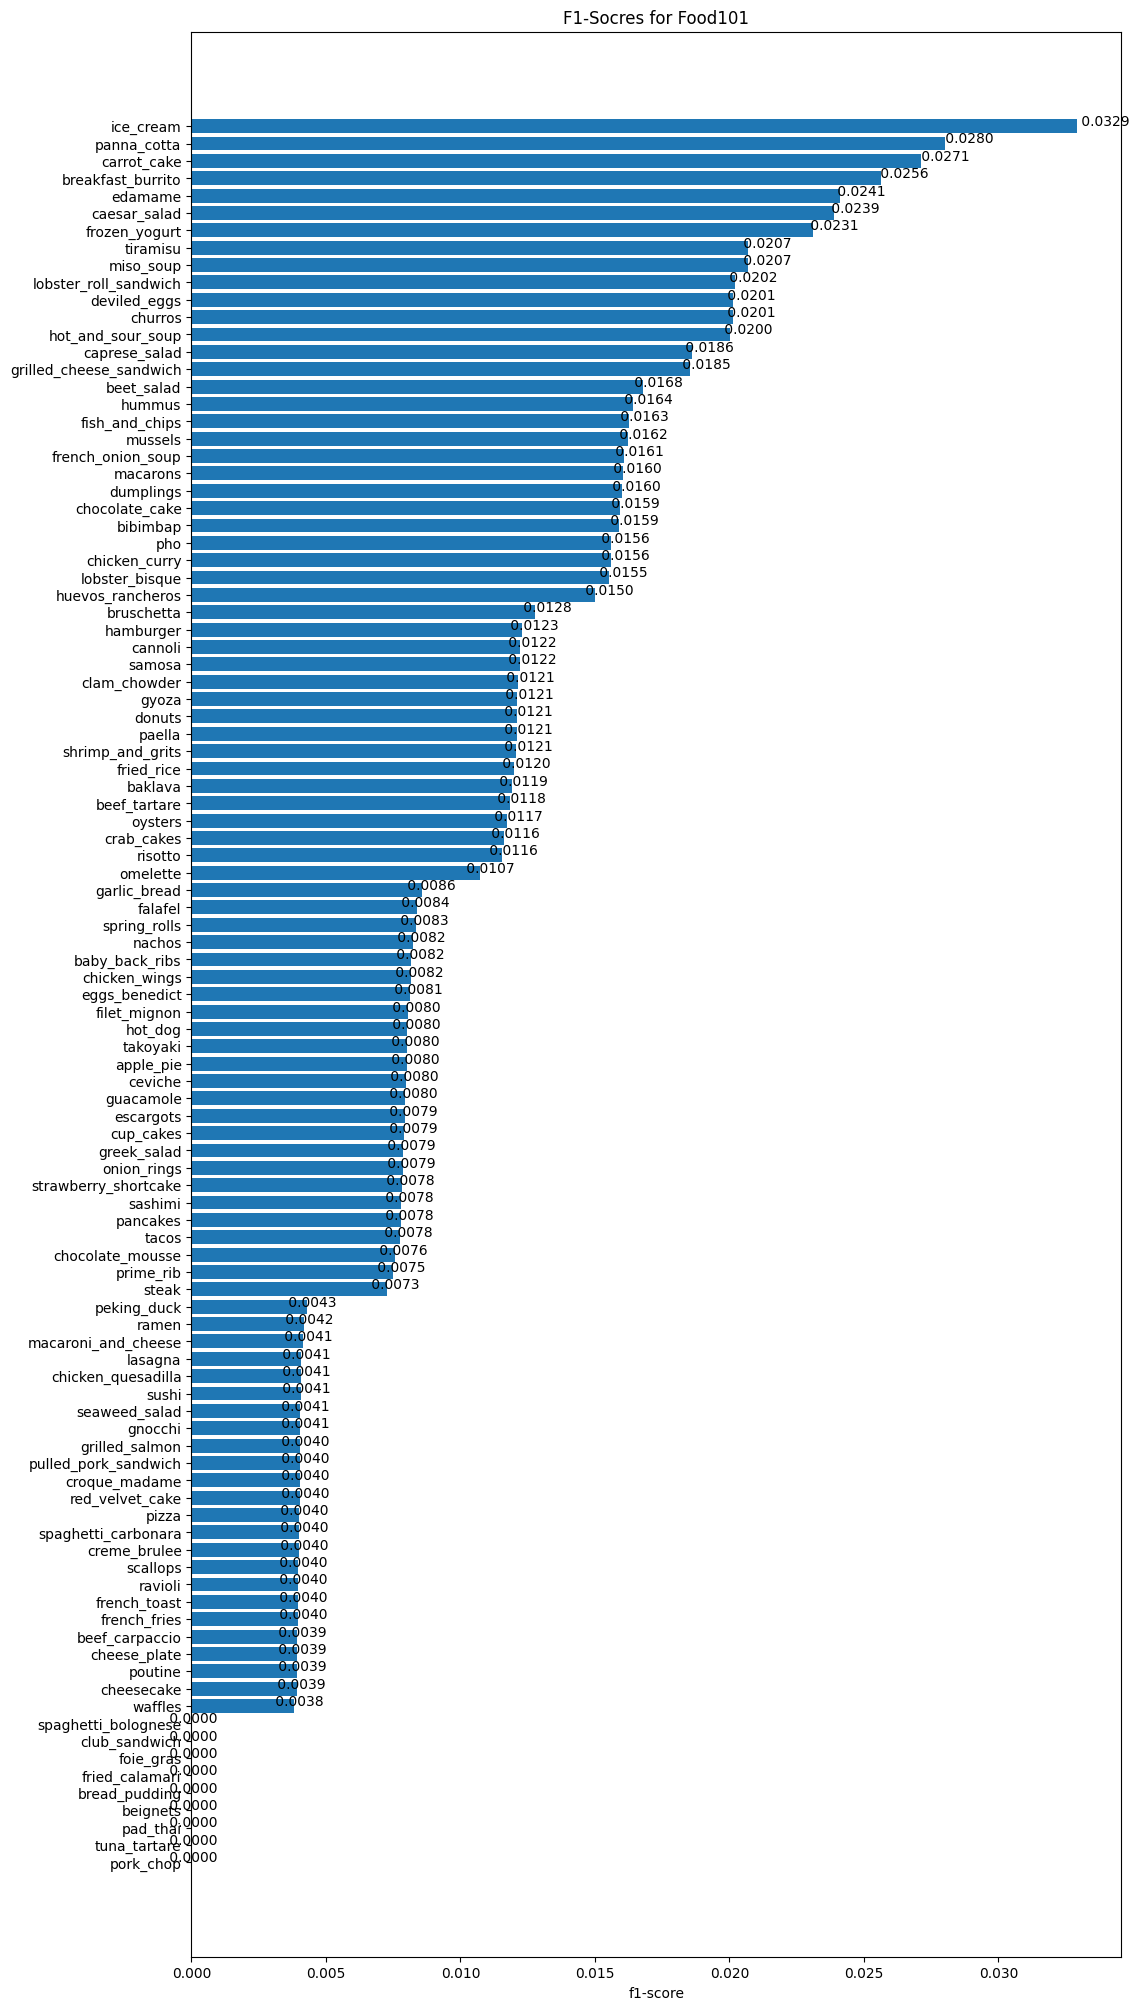

In [18]:
# Plot f1-scores
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(df_f1_scores)), df_f1_scores['f1-score'].values)
ax.set_yticks(range(len(df_f1_scores)))
ax.set_yticklabels(df_f1_scores['class_name'])
ax.set_xlabel('f1-score')
ax.set_title("F1-Socres for Food101")
ax.invert_yaxis();

def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.text(1.03 * width, rect.get_y() + rect.get_height() / 1.5,
                f"{width: .4f}",
                ha='center', va='bottom')

autolabel(scores)

In [19]:
# Get random samples from the test data
random_data = tf.data.Dataset.sample_from_datasets([test_data_prep.unbatch()])
random_data

<_UnbatchDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

1/1 [==============================] - 0s 28ms/step


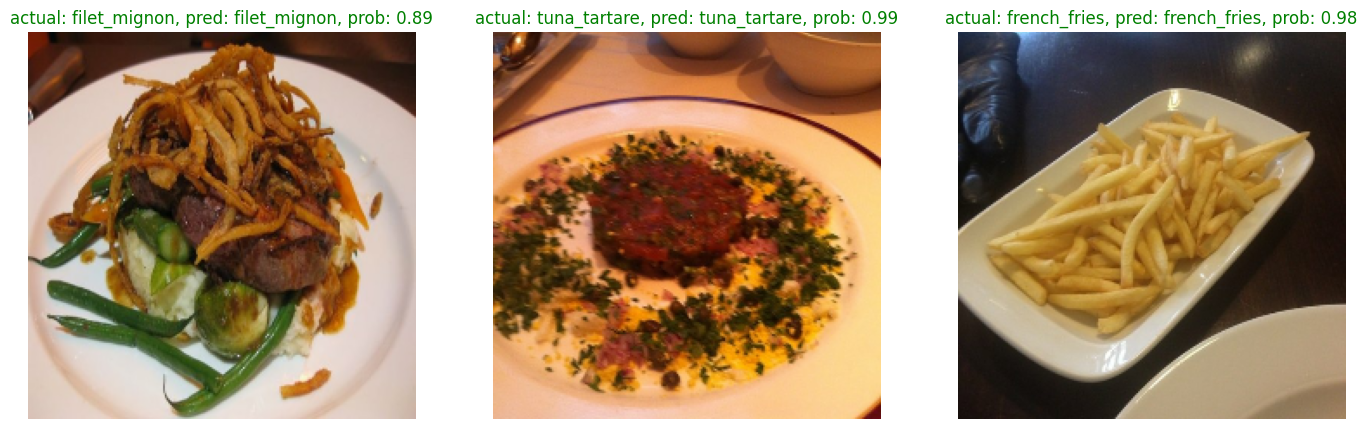

In [20]:
# Plot 3 random samples
plt.figure(figsize=(17, 10))
for i, (image, label) in enumerate(random_data.take(3)):
    class_name = class_names[label]
    pred_prob = model.predict(tf.expand_dims(image, axis = 0))
    pred_class = class_names[pred_prob.argmax()]

    plt.subplot(1, 3, i + 1)
    plt.imshow(image / 255)
    if class_name == pred_class:
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);

## 2. Take 3 of your photos of food and use the Food Vision model to make predictions on them. How does it go? Share your images/predictions with the other students.

In [21]:
# Get 3 custom photos
!wget -O "steak.jpeg" "https://images.unsplash.com/photo-1504674900247-0877df9cc836?q=80&w=2070&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
!wget -O "pizza.jpeg" "https://images.unsplash.com/photo-1571066811602-716837d681de?q=80&w=1844&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
!wget -O "pancake.jpeg" "https://images.unsplash.com/photo-1567620905732-2d1ec7ab7445?q=80&w=1980&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"

--2023-12-17 02:08:50--  https://images.unsplash.com/photo-1504674900247-0877df9cc836?q=80&w=2070&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D
Resolving images.unsplash.com (images.unsplash.com)... 146.75.82.208, 2a04:4e42:84::720
Connecting to images.unsplash.com (images.unsplash.com)|146.75.82.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 787595 (769K) [image/jpeg]
Saving to: ‘steak.jpeg’

steak.jpeg          100%[===================>] 769.14K  --.-KB/s    in 0.05s   

2023-12-17 02:08:50 (16.4 MB/s) - ‘steak.jpeg’ saved [787595/787595]

--2023-12-17 02:08:50--  https://images.unsplash.com/photo-1571066811602-716837d681de?q=80&w=1844&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D
Resolving images.unsplash.com (images.unsplash.com)... 146.75.82.208, 2a04:4e42:84::720
Connecting to images.unsplash.com (images.unsplash.com)|146.75.82.208|:443... connected.
HTTP

In [22]:
# Get image paths
import glob

filepaths = [img_f[2:] for img_f in glob.glob("./*.jpeg")]
filepaths

['pizza.jpeg', 'pancake.jpeg', 'steak.jpeg']

In [23]:
# preparing and loading image function
def load_and_prep_image(filename, img_shape=224, scale=False):
    img = tf.io.read_file(filename)
    img = tf.io.decode_image(img)
    img = tf.image.resize(img, size = [img_shape, img_shape])

    if scale:
        return img / 255
    else:
        return img

1/1 [==============================] - 0s 29ms/step


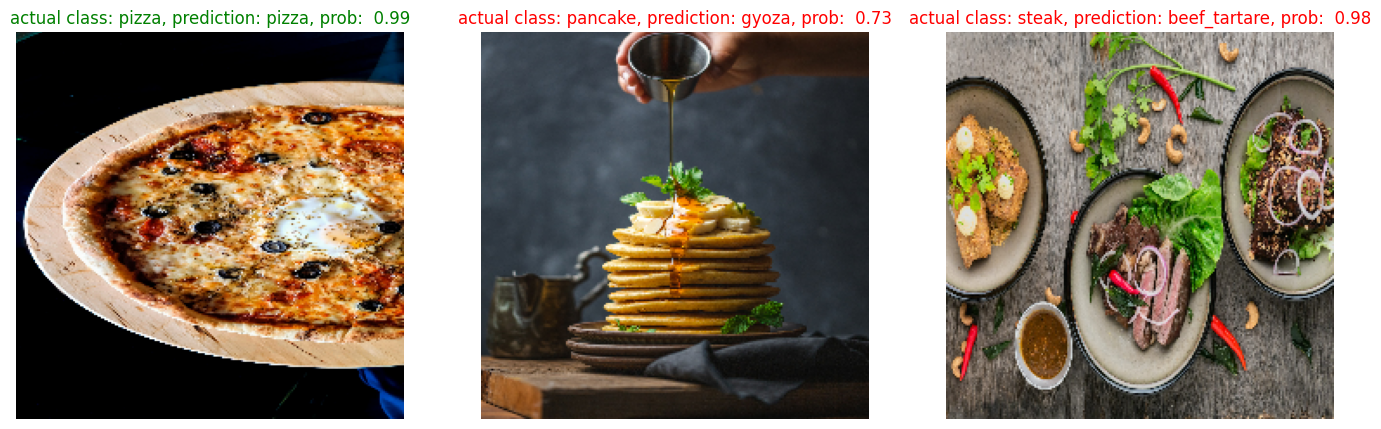

In [24]:
# Predict and plot custom images
plt.figure(figsize=(17, 10))
for i in range(len(filepaths)):
    class_name = filepaths[i].split('.')[0]
    img = load_and_prep_image(filepaths[i], scale = False)
    pred_prob = model.predict(tf.expand_dims(img, axis = 0))
    pred_class = class_names[pred_prob.argmax()]

    plt.subplot(1, 3, i + 1)
    plt.imshow(img / 255)
    if class_name == pred_class:
        plt.title(f"actual class: {class_name}, prediction: {pred_class}, prob: {pred_prob.max(): .2f}", c="g")
    else:
        plt.title(f"actual class: {class_name}, prediction: {pred_class}, prob: {pred_prob.max(): .2f}", c="r")
    plt.axis(False)

## 3. Retrain the model (feature extraction and fine-tuning) we trained in this chapter, except this time use [`EfficientNetB4`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB4) as the base model instead of `EfficientNetB0`. Do you notice a performance improvement? Does it take longer to train? Are there any tradeoffs to consider?

In [25]:
# Set mixed precision
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy(policy = "mixed_float16")

In [26]:
# Load EfficientNetB4 model
base_model = tf.keras.applications.efficientnet.EfficientNetB4(include_top = False)
base_model.trainable = False

# Build a model
inputs = tf.keras.Input(shape = (224, 224, 3))
x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation('softmax', dtype = tf.float32)(x)
model_3 = tf.keras.Model(inputs = inputs, outputs = outputs)

71686520/71686520 [==============================] - 0s 0us/step


In [27]:
# Model summary
model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional  (None, None, None, 1792   17673823  
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               181093    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                                 
Total params: 17854916 (68.11 MB)
Trainable params: 181093 (7

In [34]:
# Create callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      patience=2,
                                      verbose=1)

checkpoint_path = "model_checkpoints/cp.ckpt"
mckpt = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                           monitor='val_loss',
                                           verbose=1,
                                           save_best_only=True,
                                           save_weights_only=True)

log_dir = model_3.layers[1].name + "food101_all"
tb = tf.keras.callbacks.TensorBoard(log_dir = log_dir)

lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          factor=0.2,
                                          patience=2,
                                          verbose=1,
                                          min_lr=1e-7)

In [29]:
# Compile model
model_3.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# Train a model
model_3.fit(train_data_prep,
            epochs=100,
            steps_per_epoch=len(train_data_prep),
            validation_data=test_data_prep,
            validation_steps=int(len(test_data_prep) * 0.15),
            callbacks=[es, mckpt, tb])

Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 1.7873 - accuracy: 0.5572
Epoch 1: val_loss improved from inf to 1.25668, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 263s 102ms/step - loss: 1.7873 - accuracy: 0.5572 - val_loss: 1.2567 - val_accuracy: 0.6698
Epoch 2/100
2367/2368 [============================>.] - ETA: 0s - loss: 1.3096 - accuracy: 0.6581
Epoch 2: val_loss improved from 1.25668 to 1.16787, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 253s 105ms/step - loss: 1.3096 - accuracy: 0.6581 - val_loss: 1.1679 - val_accuracy: 0.6854
Epoch 3/100
2367/2368 [============================>.] - ETA: 0s - loss: 1.1627 - accuracy: 0.6937
Epoch 3: val_loss improved from 1.16787 to 1.11559, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 240s 100ms/step - loss: 1.1627 - accuracy: 0.6937 - val_loss: 1.1156 - val_accuracy: 0.7002
Epoch 4/100
23

In [30]:
model_3.evaluate(test_data_prep)

790/790 [==============================] - 70s 89ms/step - loss: 1.0812 - accuracy: 0.7042


[1.0811982154846191, 0.7041980028152466]

In [31]:
# Fine-tune model 3
base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

# Compile model
model_3.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# Train a model
model_3.fit(train_data_prep,
            epochs=100,
            steps_per_epoch=len(train_data_prep),
            validation_data=test_data_prep,
            validation_steps=int(len(test_data_prep) * 0.15),
            callbacks=[es, mckpt, tb])

Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 1.2737 - accuracy: 0.6599
Epoch 1: val_loss improved from 1.07328 to 1.06348, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 284s 110ms/step - loss: 1.2737 - accuracy: 0.6599 - val_loss: 1.0635 - val_accuracy: 0.6994
Epoch 2/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.8737 - accuracy: 0.7579
Epoch 2: val_loss improved from 1.06348 to 1.04489, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 260s 108ms/step - loss: 0.8738 - accuracy: 0.7580 - val_loss: 1.0449 - val_accuracy: 0.7198
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.6310 - accuracy: 0.8184
Epoch 3: val_loss did not improve from 1.04489
2368/2368 [==============================] - 258s 108ms/step - loss: 0.6310 - accuracy: 0.8184 - val_loss: 1.1493 - val_accuracy: 0.7132
Epoch 4/100
2367/2368 [============================>.] - 

In [32]:
model_3.evaluate(test_data_prep)

790/790 [==============================] - 86s 109ms/step - loss: 1.1851 - accuracy: 0.7198


[1.1850814819335938, 0.7198019623756409]

In [35]:
# Fine-tune model
base_model.trainable = True

# Compile model
model_3.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# Train a model
model_3.fit(train_data_prep,
            epochs=100,
            steps_per_epoch=len(train_data_prep),
            validation_data=test_data_prep,
            validation_steps=int(len(test_data_prep) * 0.15),
            callbacks=[es, mckpt, tb, lr])

Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 1.8650 - accuracy: 0.5269
Epoch 1: val_loss improved from inf to 1.86096, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 915s 337ms/step - loss: 1.8650 - accuracy: 0.5269 - val_loss: 1.8610 - val_accuracy: 0.5246 - lr: 0.0010
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 1.5282 - accuracy: 0.6018
Epoch 2: val_loss improved from 1.86096 to 1.57638, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 800s 337ms/step - loss: 1.5282 - accuracy: 0.6018 - val_loss: 1.5764 - val_accuracy: 0.5739 - lr: 0.0010
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 1.4802 - accuracy: 0.6123
Epoch 3: val_loss improved from 1.57638 to 1.45135, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 824s 346ms/step - loss: 1.4802 - accuracy: 0.6123 - val_loss: 1.4513 - val_accur

In [36]:
model_3.evaluate(test_data_prep)

790/790 [==============================] - 69s 87ms/step - loss: nan - accuracy: 0.0099


[nan, 0.009900989942252636]

The performance of the feature extractor and fine-tuned EfficientNetB4 (last 20 layers only) seem to be similar to the EfficientNetB0.

However, it takes longer to train as the model has more parameters.

## 4. Name one important benefit of mixed precision training, how does this benefit take place?

Mixed precision training allows the model to be trained faster without hurting the performance.

# 📖 Extra-curriculum
- Read up on learning rate scheduling and the [learning rate scheduler callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/
LearningRateScheduler). What is it? And how might it be helpful to this project?
    - LearningRateScheduler allows you to create a custom function (scheduler) to update the learning rate following the conditions you set.
    - Instead of using `ReduceLROnPlateau` we could use a different learning rate scheduler to update learning rate, either less or more depending on the model performance
- Read up on TensorFlow data loaders ([improving TensorFlow data loading performance](https://www.tensorflow.org/guide/data_performance)). Is there anything we've missed? What methods do you keep in mind whenever loading data in TensorFlow? Hint: check the summary at the bottom of the page for a great round-up of ideas.
    - We haven't used the following methods:
        - Interleave: Allows extraction of data to be performed in parallel
        - Vectorize mapping: Allows mapping function to be performed in parallel
        - Reducing memory footprint: First map time-consuming function and apply `.cache()` then apply memory-consuming function
            - e.g. ```dataset.map(time_consuming_mapping).cache().map(memory_consuming_mapping)```
        - All options allow faster data loading
- Read up on the documentation for [TensorFlow mixed precision training](https://www.tensorflow.org/guide/mixed_precision). What are the important things to remember when using mixed precision training?
    - Set global policy before model building
    - Always apply `dtype=tf.float32` for the output layer
    - Only NVIDIA GPUs with scores of 7.0 or above receive the benefit from using mixed precision